# Compute performance of Decima at predicting disease vs. healthy log fold changes

In [1]:
import numpy as np
import pandas as pd
import anndata
from tqdm import tqdm
import os, sys
from grelu.visualize import plot_distribution

sys.path.append('/code/decima/src/decima')

import interpret
from plotnine import *
%matplotlib inline

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Paths

In [2]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823/"
matrix_file = os.path.join(save_dir, "data.h5ad")
h5_file = os.path.join(save_dir, "data.h5")
ckpt_dir = os.path.join(save_dir, 'lightning_logs')

## Load data

In [3]:
ad = anndata.read_h5ad(matrix_file)
ad = ad[:, ad.var.dataset=="test"]

## Compute correlation for all disease - healthy pairs

In [4]:
results = []
for disease in tqdm(ad.obs.disease.unique()):
    if disease not in ["healthy", "NA"]:
            
        for study, tissue, ct in ad.obs.loc[(ad.obs.disease==disease), ['study', 'tissue', 'cell_type']].itertuples(index=False):
            
            d_ad = ad[(ad.obs.disease==disease) & (ad.obs.study == study) & (ad.obs.tissue == tissue) & (ad.obs.cell_type==ct)]
            h_ad = ad[(ad.obs.disease == "healthy") &  (ad.obs.study == study) & (ad.obs.tissue == tissue) & (ad.obs.cell_type==ct)]

            if (len(h_ad) > 0):
                h_track = h_ad.obs.index.tolist()[0]
                d_track = d_ad.obs.index.tolist()[0]

                true_lfc = np.squeeze(d_ad.X - h_ad.X)
                pred_lfc = np.squeeze(d_ad.layers['preds'] - h_ad.layers['preds'])
                curr_lfc = pd.DataFrame({'true':true_lfc, 'pred':pred_lfc})
        
                corr = np.round(curr_lfc.corr().iloc[0, 1], 2)
                n_de = np.sum(np.abs(curr_lfc.true) > 1)
                sf_lfc = (d_ad.obs['size_factor'].values[0] - h_ad.obs['size_factor'].values[0])/27249
    
                results.append((disease, study, tissue, ct, h_track, d_track, corr, n_de, sf_lfc))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:19<00:00,  4.14it/s]


In [5]:
results = pd.DataFrame(results, columns=["disease", "study", "tissue", "cell_type", "healthy_track", 
                            "disease_track", "lfc_pearson", "n_de", 'lfc_sf'])

In [6]:
results = results.merge(ad.obs[['n_cells', 'total_counts', 'n_genes']], left_on='healthy_track', right_index=True)
results = results.merge(ad.obs[['n_cells', 'total_counts', 'n_genes']], left_on='disease_track', right_index=True)
results.columns = results.columns[:-6].tolist() + ['healthy_cells', 'healthy_counts', 'healthy_n_genes', 'disease_cells', 'disease_counts', 'disease_n_genes']

## Filter disease-healthy pairs

In [7]:
print(len(results[(results.disease_cells > 500) & (results.healthy_cells > 500)]))

565


In [8]:
results[(results.disease_cells > 500) & (results.healthy_cells > 500)].lfc_pearson.mean()

np.float64(0.2440353982300885)

## Visualize histogram of performance

/opt/conda/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 20'. Pick better value with 'binwidth'.


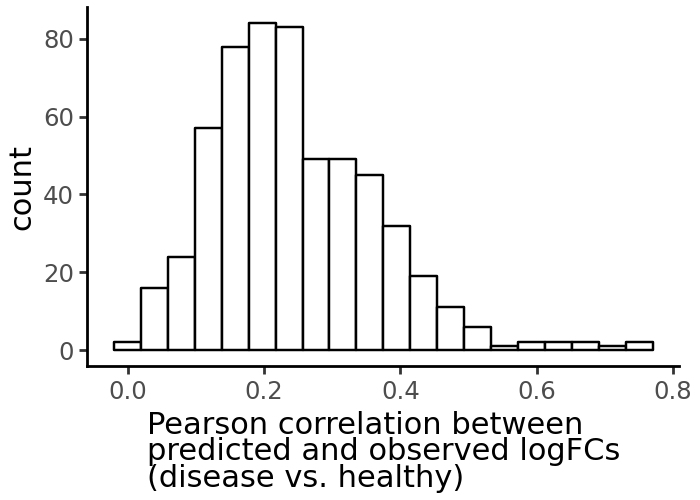

In [9]:
plot_distribution(results[(results.disease_cells > 500) & (results.healthy_cells > 500)].lfc_pearson, 
                  fill='white', color='black', figsize=(3.5, 2.5)) + xlab(
    'Pearson correlation between\npredicted and observed logFCs\n(disease vs. healthy)')